In [2]:
from known_boundary.GP import optimise,optimise_warp
from known_boundary.utlis import Trans_function, get_initial_points
from known_boundary.acquisition_function import EI_acquisition_opt,MES_acquisition_opt,Warped_TEI2_acquisition_opt

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import GPy
import torch
import botorch
from botorch.test_functions import Ackley,Levy,Beale,Branin,Hartmann,Rosenbrock
from botorch.utils.transforms import unnormalize,normalize

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.double

In [7]:
fun = Levy(dim=4,negate=False)
dim = fun.dim
bounds = fun.bounds
standard_bounds=np.array([0.,1.]*dim).reshape(-1,2)
 
n_init = 4*dim
iter_num = 10*dim
N=1

fstar = 0.
fun = Trans_function(fun,fstar,min=True)

# GP+EI

In [12]:
BO_EI = []

for exp in range(N):
    
    print(exp)

    seed = exp

    X_BO = get_initial_points(bounds, n_init,device,dtype,seed=seed)
    Y_BO = torch.tensor(
        [fun(x) for x in X_BO], dtype=dtype, device=device
    ).reshape(-1,1)

    #torch.manual_seed(seed)

    best_record = [Y_BO.min().item()]

    for i in range(iter_num):
        
            train_Y = (Y_BO - Y_BO.mean()) / Y_BO.std()
            train_X = normalize(X_BO, bounds)
            
            minimal = train_Y.min().item()
            
            train_Y = train_Y.numpy()
            train_X = train_X.numpy()
            
            # train the GP
            res = optimise(train_X,train_Y)
            print('lengthscale is: ',np.sqrt(res[0])) 
            print('variance is: ',res[1])
            kernel = GPy.kern.RBF(input_dim=dim,lengthscale= np.sqrt(res[0]),variance=res[1]) 
            m = GPy.models.GPRegression(train_X, train_Y,kernel)
            m.Gaussian_noise.variance.fix(10**(-5))

            standard_next_X = EI_acquisition_opt(m,bounds=standard_bounds,f_best=minimal)
            X_next = unnormalize(torch.tensor(standard_next_X), bounds).reshape(-1,dim)            
            Y_next = fun(X_next).reshape(-1,1)

            # Append data
            X_BO = torch.cat((X_BO, X_next), dim=0)
            Y_BO = torch.cat((Y_BO, Y_next), dim=0)
            
            best_record.append(Y_BO.min().item())
            #print(best_record)
            
    best_record = np.array(best_record)+fstar 
    BO_EI.append(best_record)

0
lengthscale is:  0.3273816309516063
variance is:  1.060748514931474
lengthscale is:  0.27324993082608906
variance is:  0.9250767392903296
lengthscale is:  0.2946478070488695
variance is:  0.9487288320452513
lengthscale is:  0.3182579523888689
variance is:  1.0021624390296173
lengthscale is:  0.3330901006023945
variance is:  1.0444640789161295
lengthscale is:  0.3406680061897725
variance is:  1.0704578505817761
lengthscale is:  0.350083785753464
variance is:  1.1070946595167939
lengthscale is:  0.36650501401995966
variance is:  1.182604357112496
lengthscale is:  0.37040345036994177
variance is:  1.203645692772834
lengthscale is:  0.357129349326751
variance is:  1.1646754256676286
lengthscale is:  0.3733881368080188
variance is:  1.2452299153761208
lengthscale is:  0.37551465989646005
variance is:  1.2595212429448845
lengthscale is:  0.38748148945635924
variance is:  1.3345447905582104
lengthscale is:  0.39287096452699904
variance is:  1.387014594303233
lengthscale is:  0.3956853400852

# GP+MES

In [13]:
BO_MES = []

for exp in range(N):
    
    print(exp)

    seed = exp
    

    X_BO = get_initial_points(bounds, n_init,device,dtype,seed=seed)
    Y_BO = torch.tensor(
        [fun(x) for x in X_BO], dtype=dtype, device=device
    ).reshape(-1,1)
    
    fstar_mes = 0.
    
    #torch.manual_seed(seed)

    best_record = [Y_BO.min().item()]

    for i in range(iter_num):
        
            train_Y = (Y_BO - Y_BO.mean()) / Y_BO.std()
            train_X = normalize(X_BO, bounds)
            
            
            fstar_standard = (fstar_mes - Y_BO.mean()) / Y_BO.std()
            fstar_standard = fstar_standard.item()
            
            train_Y = train_Y.numpy()
            train_X = train_X.numpy()
            
            # train the GP
            res = optimise(train_X,train_Y)
            print('lengthscale is: ',np.sqrt(res[0])) 
            print('variance is: ',res[1])
            kernel = GPy.kern.RBF(input_dim=dim,lengthscale= np.sqrt(res[0]),variance=res[1]) 
            m = GPy.models.GPRegression(train_X, train_Y,kernel)
            m.Gaussian_noise.variance.fix(10**(-5))

            standard_next_X = MES_acquisition_opt(m,standard_bounds,fstar_standard)
            X_next = unnormalize(torch.tensor(standard_next_X), bounds).reshape(-1,dim)            
            Y_next = fun(X_next).reshape(-1,1)

            # Append data
            X_BO = torch.cat((X_BO, X_next), dim=0)
            Y_BO = torch.cat((Y_BO, Y_next), dim=0)
            
            best_record.append(Y_BO.min().item())

            
    best_record = np.array(best_record)+fstar 
    BO_MES.append(best_record)

0
lengthscale is:  0.32738168412311275
variance is:  1.0607487399963613
lengthscale is:  0.25283439523398615
variance is:  0.9114543119152451
lengthscale is:  0.2741283964502178
variance is:  0.9298520731968521
lengthscale is:  0.30495592669453786
variance is:  1.0090696535886179
lengthscale is:  0.31627552823121097
variance is:  1.0377858876380288
lengthscale is:  0.3249160794152208
variance is:  1.0666687422099337
lengthscale is:  0.3450373070007615
variance is:  1.1583647939564914
lengthscale is:  0.36641667649548676
variance is:  1.2852051111072458
lengthscale is:  0.38485800521639396
variance is:  1.4123648273147946
lengthscale is:  0.3985781504454699
variance is:  1.518212951312542
lengthscale is:  0.4097249281146705
variance is:  1.6151006464323143
lengthscale is:  0.4329812591954822
variance is:  1.8531600033799793
lengthscale is:  0.42681390297168575
variance is:  1.8286270955470945
lengthscale is:  0.424443892157595
variance is:  1.8300202290191103
lengthscale is:  0.43940134

# log GP+TEI

In [8]:
Warped_BO_TEI2 = []

for exp in range(N):
    
    print(exp)

    seed = exp

    X_BO = get_initial_points(bounds, n_init,device,dtype,seed=seed)
    Y_BO = torch.tensor(
        [fun(x) for x in X_BO], dtype=dtype, device=device
    ).reshape(-1,1)

    #torch.manual_seed(seed)

    best_record = [Y_BO.min().item()]

    for i in range(iter_num):
            
            print(i)
        
            train_Y = Y_BO.numpy()
            train_X = normalize(X_BO, bounds)
            train_X = train_X.numpy()
            
            # train the GP
            res = optimise_warp(train_X, train_Y)
            lengthscale = np.sqrt(res[0])
            variance = res[1]
            c = res[2]
            
            print('lengthscale is: ', lengthscale)
            print('variance is: ',variance)
            print('c is: ',c)
            
            warp_Y = np.log(train_Y+c)
            mean_warp_Y = np.mean(warp_Y) # use to predict mean
            warp_Y_standard = warp_Y-mean_warp_Y
              
            
            kernel = GPy.kern.RBF(input_dim=dim,lengthscale= lengthscale,variance=variance)  #np.sqrt(res[0])
            m = GPy.models.GPRegression(train_X, warp_Y_standard,kernel)
            m.Gaussian_noise.variance.fix(10**(-5))
            
            standard_next_X = Warped_TEI2_acquisition_opt(model=m,bounds=standard_bounds,f_best=best_record[-1],c=c,f_mean=mean_warp_Y)
            X_next = unnormalize(torch.tensor(standard_next_X), bounds).reshape(-1,dim)            
            Y_next = fun(X_next).reshape(-1,1)

            # Append data
            X_BO = torch.cat((X_BO, X_next), dim=0)
            Y_BO = torch.cat((Y_BO, Y_next), dim=0)
            
            best_record.append(Y_BO.min().item())
            print(best_record[-1])
            
    best_record = np.array(best_record)+fstar         
    Warped_BO_TEI2.append(best_record)

0
0
lengthscale is:  0.23736314599222927
variance is:  0.8038343022226284
c is:  0.3
2.6433921985731614
1
lengthscale is:  0.2540315632452772
variance is:  0.8413414050964508
c is:  0.3
2.6433921985731614
2
lengthscale is:  0.2293024601537136
variance is:  0.8995057688745225
c is:  0.3
1.2335599606464704
3
lengthscale is:  0.22002030183261218
variance is:  1.1120899337253454
c is:  0.3
0.7279121190109192
4
lengthscale is:  0.26401846393227174
variance is:  1.4442335221905318
c is:  0.3
0.7279121190109192
5
lengthscale is:  0.12653822842330986
variance is:  1.4191220309533035
c is:  0.3
0.7279121190109192
6
lengthscale is:  0.1112679558685636
variance is:  1.425793692231544
c is:  0.3
0.7279121190109192
7
lengthscale is:  0.09878670218970892
variance is:  1.5389927835622002
c is:  0.3
0.6906833463395579
8
lengthscale is:  0.09326878535467423
variance is:  1.577548380305555
c is:  0.3
0.322698443234546
9
lengthscale is:  0.09380987062149274
variance is:  1.755736433199807
c is:  0.3
0.27

# plot

Text(0.5, 1.0, 'Ackley2D')

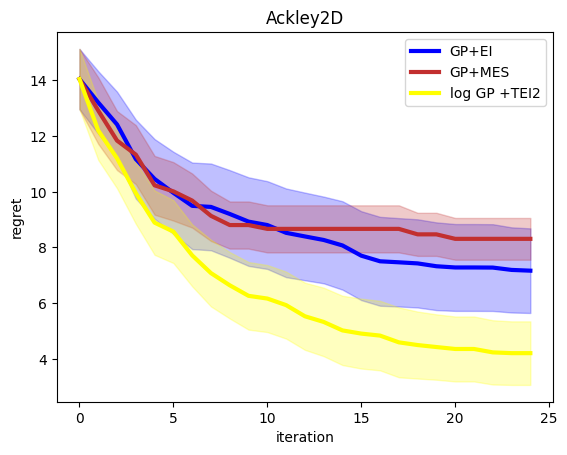

In [8]:
fstar = 0.
N = 20

total_record = np.array(BO_EI)-fstar
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,label='GP+EI',color='blue')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N),alpha=0.25,color='blue')

total_record = np.array(BO_MES)-fstar
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,label='GP+MES',color='#c22f2f')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N),alpha=0.25,color='#c22f2f')

total_record = np.array(Warped_BO_TEI2)-fstar
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,label='log GP +TEI2',color='yellow')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N),alpha=0.25,color='yellow')



plt.xlabel('iteration')
plt.ylabel('regret')

plt.legend()
plt.title('Ackley2D')

Text(0.5, 1.0, 'Rosenbrock4D')

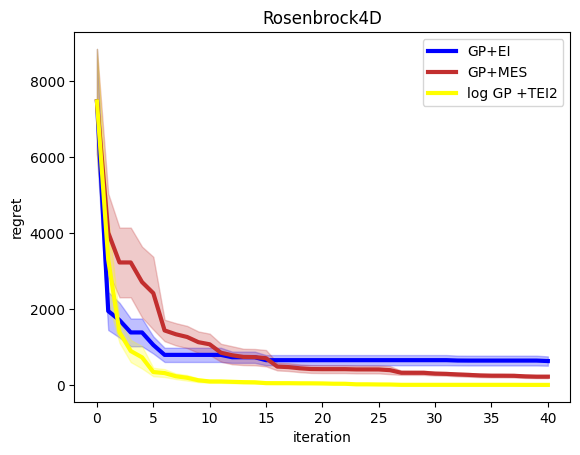

In [17]:
fstar = 0.
N = 14

total_record = np.array(BO_EI)-fstar
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,label='GP+EI',color='blue')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N),alpha=0.25,color='blue')

total_record = np.array(BO_MES)-fstar
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,label='GP+MES',color='#c22f2f')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N),alpha=0.25,color='#c22f2f')

total_record = np.array(Warped_BO_TEI2)-fstar
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,label='log GP +TEI2',color='yellow')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N),alpha=0.25,color='yellow')



plt.xlabel('iteration')
plt.ylabel('regret')

plt.legend()
plt.title('Rosenbrock4D')